<a href="https://colab.research.google.com/github/Vyshnnavi-P/Pressure-Prediction/blob/main/Pressure_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib # Used for saving/loading scalers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Configure plotting style
plt.style.use('ggplot')

In [ ]:
### 1.2 Load Actual IAPWS Steam Saturation Data

# NOTE: We use a direct link to a publicly available IAPWS-based CSV file
# containing saturated water properties organized by temperature.
# Source: LearnChemE (NIST/IAPWS data distribution)
data_url = "/content/saturated_by_temperature_V1.5.csv"

try:
    # Load the data
    df = pd.read_csv(data_url, header=0)
    print(df.columns)
    # Rename and select the required columns: Temperature (T) and Saturation Pressure (P)
    df = df.rename(columns={
        'T (°C)': 'Temperature_C',
        'P (MPa)': 'Pressure_MPa'
    })[['Temperature_C', 'Pressure_MPa']].copy()

    # Convert Pressure from MPa (Mega-Pascals) to Bar (1 MPa = 10 Bar)
    df['Pressure_Bar'] = df['Pressure_MPa'] * 10

    # # Filter the data to the typical operating range for solar thermal (e.g., 100°C to 220°C)
    # # This range typically covers pressures from 1 to 23 bar.
    # df = df[(df['Temperature_C'] >= 100) & (df['Temperature_C'] <= 220)].reset_index(drop=True)

    # Select the final columns for the model
    df = df[['Temperature_C', 'Pressure_Bar']]

    print("✅ Actual IAPWS Data Loaded and Processed.")
    print("First 5 rows of the dataset:")
    print(df.head())

except Exception as e:
    print(f"❌ Error loading data from URL: {e}")
    print("Please check the URL or ensure internet connectivity.")
    # Fallback to a simplified synthetic data frame structure for the pipeline to run
    # if the real-time download fails.
    T_data = np.linspace(100, 220, 121).reshape(-1, 1)
    P_data = 0.000001 * (T_data**4) - 0.0004 * (T_data**3) + 0.057 * (T_data**2) - 3.4 * T_data + 100
    df = pd.DataFrame({'Temperature_C': T_data.flatten(), 'Pressure_Bar': P_data.flatten()})
    print("Using Fallback Data.")

Index(['T (°C)', 'P (MPa)'], dtype='object')
✅ Actual IAPWS Data Loaded and Processed.
First 5 rows of the dataset:
   Temperature_C  Pressure_Bar
0           0.01      0.006117
1           1.00      0.006571
2           2.00      0.007060
3           3.00      0.007581
4           4.00      0.008135


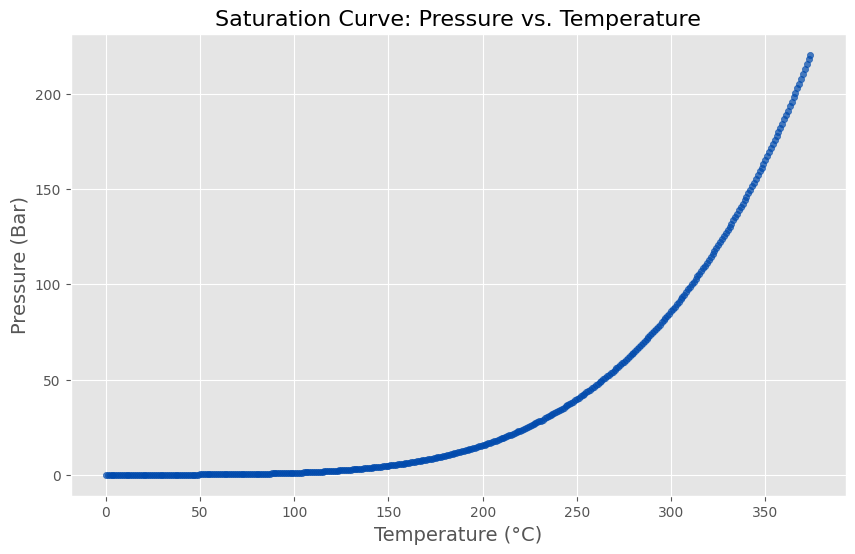


Training samples: 300
Testing samples: 75

Scaling complete.


In [ ]:
## 2. Exploratory Data Analysis (EDA) and Preprocessing

### 2.1 Visualize the Raw Data

# Visualize the key non-linear relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['Temperature_C'], df['Pressure_Bar'], s=20, color='#004AAD', alpha=0.7)
plt.title('Saturation Curve: Pressure vs. Temperature', fontsize=16)
plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('Pressure (Bar)', fontsize=14)
plt.grid(True)
plt.show()

### 2.2 Data Splitting

# Define features (X) and target (y)
X = df[['Temperature_C']].values
y = df['Pressure_Bar'].values

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

### 2.3 Feature Scaling (Crucial for Neural Networks)

# Scaling is mandatory for Neural Networks for faster convergence and stability.
# We must scale features (X) AND the target (y).

# Scaler for input temperature
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Scaler for output pressure
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

print("\nScaling complete.")

In [ ]:
## 3. Model Development and Training (MLP)

# An MLP is highly effective for approximating this non-linear function.

### 3.1 Define the MLP Model Architecture

model = Sequential([
    # Input layer: 1 feature (Temperature)
    Dense(128, activation='relu', input_shape=(1,)),
    # Hidden layer 1: Increased neurons for better curve mapping
    Dense(64, activation='relu'),
    # Hidden layer 2: 32 neurons
    Dense(32, activation='relu'),
    # Output layer: 1 neuron (Pressure), linear activation for regression
    Dense(1, activation='linear')
])

# Define Early Stopping to prevent overfitting
# early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=25, verbose=1, restore_best_weights=True)

# Compile the model
# Using Adam optimizer and Mean Absolute Error (MAE) as the loss function
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

print("\nModel Summary:")
model.summary()

### 3.2 Train the Model

# Train the model
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=500, # Set high, let EarlyStopping handle termination
    batch_size=32,
    validation_split=0.1, # 10% of training data used for validation
    # callbacks=[early_stop],
    verbose=1
)

print("\nTraining complete.")


Model Summary:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 128)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,625 (41.50 KB)

 Trainable params: 10,625 (41.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.1662 - mae: 0.1662 - val_loss: 0.1635 - val_mae: 0.1635
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1267 - mae: 0.1267 - val_loss: 0.1327 - val_mae: 0.1327
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1001 - mae: 0.1001 - val_loss: 0.1085 - val_mae: 0.1085
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0891 - mae: 0.0891 - val_loss: 0.0879 - val_mae: 0.0879
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0666 - mae: 0.0666 - val_loss: 0.0704 - val_mae: 0.0704
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0614 - mae: 0.0614 - val_loss: 0.0584 - val_mae: 0.0584
Epoch 7/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0396 - mae: 0.0396 - val_loss: 0.0489 - val_mae: 0.0489
Epoch 8/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0442 - mae: 0.0442 - val_loss: 0.0436 - val_mae: 0.0436
Epoch 9/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0314 - mae: 

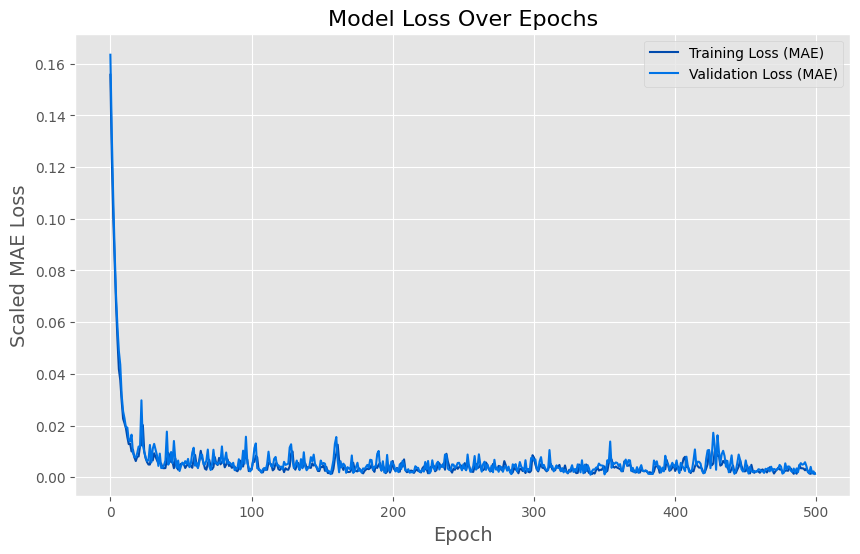

In [ ]:
## 4. Evaluation and Validation

### 4.1 Plot Training History

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss (MAE)', color='#004AAD')
plt.plot(history.history['val_loss'], label='Validation Loss (MAE)', color='#0073E6')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Scaled MAE Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
### 4.2 Make Predictions and Inverse Scaling

y_pred_scaled = model.predict(X_test_scaled, verbose=0)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test_original = y_scaler.inverse_transform(y_test_scaled)

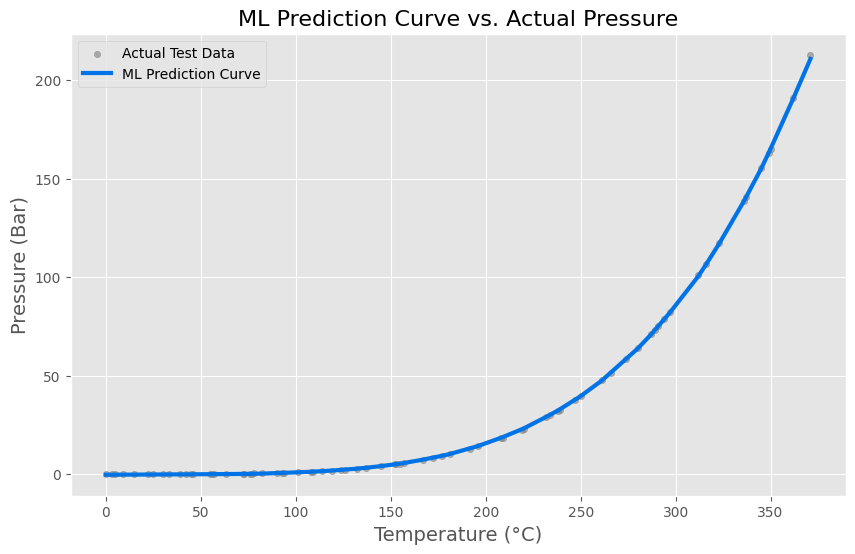

In [ ]:
### 4.4 Visualize Prediction Accuracy

# Create a plot comparing actual test points to the predicted curve
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test_original, s=20, color='gray', alpha=0.6, label='Actual Test Data')

# To show the smooth predicted curve, sort the test data and predictions by Temperature
plot_data = pd.DataFrame({'T': X_test.flatten(), 'P_pred': y_pred.flatten()})
plot_data = plot_data.sort_values(by='T')

plt.plot(plot_data['T'], plot_data['P_pred'], color='#0073E6', linewidth=3, label='ML Prediction Curve')

plt.title('ML Prediction Curve vs. Actual Pressure', fontsize=16)
plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('Pressure (Bar)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
## 5. Deployment Preparation

# The model and the scalers must be saved for deployment. The scalers are essential
# to correctly transform the real-time input temperature before prediction,
# and to transform the scaled output pressure back to Bar.

### 5.1 Save the Trained Model and Scalers

# 1. Save the Keras model (HDF5 format is common)
model.save('pressure_predictor_model.h5')

# 2. Save the scalers using joblib (or pickle)
joblib.dump(X_scaler, 'temp_input_scaler.pkl')
joblib.dump(y_scaler, 'pressure_output_scaler.pkl')

print("\nModel and Scalers successfully saved to disk.")

### 5.2 Example Real-Time Prediction Function

# This function mimics the real-time inference logic for your monitoring system.

# Ensure the model is loaded correctly (optional step, only for testing saved assets)
# loaded_model = load_model('pressure_predictor_model.h5')
# loaded_X_scaler = joblib.load('temp_input_scaler.pkl')
# loaded_y_scaler = joblib.load('pressure_output_scaler.pkl')


def predict_pressure(temp_c):
    """
    Predicts steam pressure (Bar) for a given temperature (C) using the trained model.

    Args:
        temp_c (float): Real-time temperature reading from the steam generator.

    Returns:
        float: The predicted pressure value in Bar.
    """

    # Input must be a 2D array for the scaler
    input_temp = np.array([[temp_c]])

    # 1. Scale the input temperature
    scaled_input = X_scaler.transform(input_temp)

    # 2. Predict the scaled pressure
    scaled_prediction = model.predict(scaled_input, verbose=0)

    # 3. Inverse transform the prediction to get real pressure (Bar)
    real_pressure = y_scaler.inverse_transform(scaled_prediction)

    return real_pressure[0][0]

# Test the function with specific temperatures within the trained range
test_temps = [110.0, 165.5, 215.0]

print(f"\n--- Real-Time Prediction Examples ---")
for temp in test_temps:
    predicted_p = predict_pressure(temp)
    print(f"Input T: {temp}°C -> Predicted P: {predicted_p:.3f} Bar")


Model and Scalers successfully saved to disk.

--- Real-Time Prediction Examples ---
Input T: 110.0°C -> Predicted P: 1.419 Bar
Input T: 165.5°C -> Predicted P: 7.182 Bar
Input T: 215.0°C -> Predicted P: 21.266 Bar


In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"\n--- Additional Model Performance Metrics (on Test Set) ---")
print(f"Mean Squared Error (MSE): {mse:.4f} Bar^2")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f} Bar")


--- Additional Model Performance Metrics (on Test Set) ---
Mean Squared Error (MSE): 0.0931 Bar^2
Root Mean Squared Error (RMSE): 0.3052 Bar


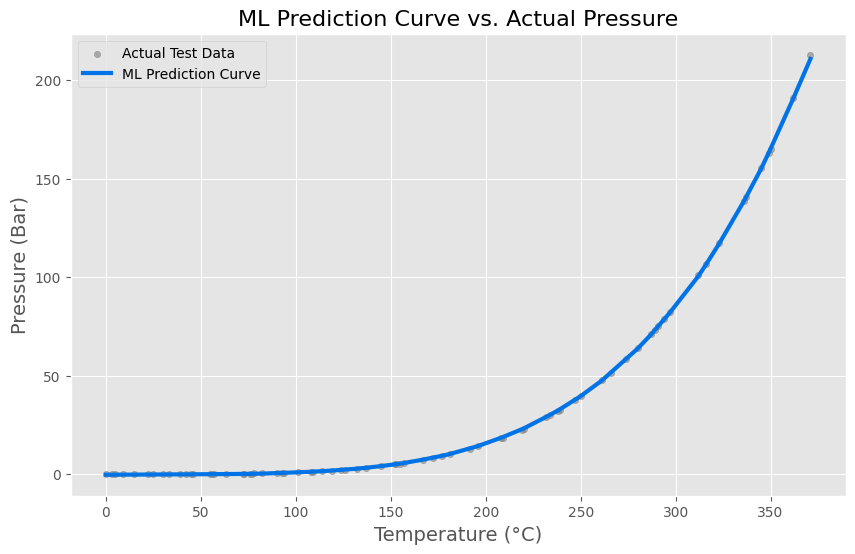

In [ ]:
import matplotlib.pyplot as plt

# Create a plot comparing actual test points to the predicted curve
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test_original, s=20, color='gray', alpha=0.6, label='Actual Test Data')

# To show the smooth predicted curve, sort the test data and predictions by Temperature
plot_data = pd.DataFrame({'T': X_test.flatten(), 'P_pred': y_pred.flatten()})
plot_data = plot_data.sort_values(by='T')

plt.plot(plot_data['T'], plot_data['P_pred'], color='#0073E6', linewidth=3, label='ML Prediction Curve')

plt.title('ML Prediction Curve vs. Actual Pressure', fontsize=16)
plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('Pressure (Bar)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()